In [1]:
import pandas as pd
import numpy as np
import pubchempy as pcp
from mordred import Calculator, descriptors
from rdkit import Chem
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from collections import Counter

from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.model_selection import cross_val_score
from skopt.plots import plot_convergence

from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from matplotlib import pyplot as plt

In [2]:
scaler = StandardScaler()

In [3]:
''' [1] https://pubs.acs.org/doi/10.1021/acs.energyfuels.6b03251'''
mult_obj        = pd.read_csv(r'C:\Users\zcemg08\PycharmProjects\biofuels\data\octane_data_multobj_paper.csv')


ron             = pd.read_csv(r'C:\Users\zcemg08\PycharmProjects\biofuels\data\ron_database_v1.0.csv',low_memory=False)

''' [3] https://pubs.acs.org/doi/10.1021/acs.energyfuels.6b01952'''
ron_biocompound = pd.read_table(r'C:\Users\zcemg08\PycharmProjects\biofuels\data\RON.txt')

In [4]:
mult_obj.head(5)

,RON_Molecules_x,ZM2V,IC1,SPAN,RDF020m,Mor03u,Mor16m,Mor31m,Mor29v,Mor10p,nCp,ALOGP2,ALOGPS_logS,Data Set,Predicted,Absolute Error,SMILES,RON_Molecules_y,Experiment
0,n-Butylbenzene,1.483,1.270,2.057,0.115,-0.406,0.720,-0.103,0.659,-0.760,-1.034,0.967,-0.864,Training,100.58,3.82,CCCCc1ccccc1,n-Butylbenzene,104.4
1,"1,2,3,4-Tetramethylbenzene",2.313,0.364,-0.096,-0.195,0.633,0.932,-1.054,0.680,-0.656,1.243,1.120,-0.374,Training,107.59,2.29,Cc1c(C)ccc(c1C)C,"1,2,3,4-Tetramethylbenzene",105.3
2,1-Phenylpentane,1.657,1.186,2.895,0.367,-0.932,0.272,0.442,0.520,-0.710,-1.034,1.779,-1.228,Training,89.73,0.53,CCCCCc1ccccc1,1-Phenylpentane,89.2
3,1-Methyl-2-allylbenzene,2.051,1.832,0.829,0.864,0.735,1.011,-0.526,0.541,-1.457,-1.034,0.392,-0.508,Training,101.42,2.82,C=CCc1ccccc1C,1-Methyl-2-allylbenzene,98.6
4,"1,2,3,4-Tetrahydronaphthalene",2.225,1.327,-0.043,0.115,-0.342,0.484,0.425,0.017,0.747,-1.793,0.421,-0.441,Training,102.26,5.86,C1CCc2c(C1)cccc2,"1,2,3,4-Tetrahydronaphthalene",96.4


In [5]:
count = Counter

In [6]:
print('data set size = {},data column types = {}'.format(len(mult_obj),count(mult_obj.dtypes)))
mult_obj.dtypes

data set size = 281,data column types = Counter({dtype('float64'): 15, dtype('O'): 4})


RON_Molecules_x     object
ZM2V               float64
IC1                float64
SPAN               float64
RDF020m            float64
Mor03u             float64
Mor16m             float64
Mor31m             float64
Mor29v             float64
Mor10p             float64
nCp                float64
ALOGP2             float64
ALOGPS_logS        float64
Data Set            object
Predicted          float64
Absolute  Error    float64
SMILES              object
RON_Molecules_y     object
Experiment         float64
dtype: object

In [7]:
ron.head(5)

,DATAID,ASSIGNMENT,Compound Name,SMILES,PubChem CID,Notes,Source,Literature Source,Formula,Validated By,...,CATS3D_10_LL,CATS3D_11_LL,CATS3D_12_LL,CATS3D_13_LL,CATS3D_14_LL,CATS3D_15_LL,CATS3D_16_LL,CATS3D_17_LL,CATS3D_18_LL,CATS3D_19_LL
0,UMLRON0001,L,1-Butanol,CCCCO,263,NaN,"Sandia, UML",[6],C4H10O,PubChem,...,0,0,0,0,0,0,0,0,0,0
1,UMLRON0002,L,Ethanol,CCO,702,NaN,"Sandia, UML",[6],C2H6O,PubChem,...,0,0,0,0,0,0,0,0,0,0
2,UMLRON0003,L,Methanol,CO,887,NaN,"Sandia, UML",[11],CH4O,PubChem,...,0,0,0,0,0,0,0,0,0,0
3,UMLRON0004,L,n-Propanol,CCCO,1031,NaN,"Sandia, UML",[6],C3H8O,PubChem,...,0,0,0,0,0,0,0,0,0,0
4,UMLRON0005,L,Toluene,CC1=CC=CC=C1,1140,Averaged sensitivity values,"Sandia, UML","[1], [3]",C7H8,PubChem,...,0,0,0,0,0,0,0,0,0,0


In [8]:
print('data set size = {},data column types = {}'.format(len(ron),count(ron.dtypes)))


data set size = 308,data column types = Counter({dtype('int64'): 3768, dtype('float64'): 1539, dtype('O'): 10})


In [9]:
ron.dtypes

DATAID           object
ASSIGNMENT       object
Compound Name    object
SMILES           object
PubChem CID       int64
                  ...  
CATS3D_15_LL      int64
CATS3D_16_LL      int64
CATS3D_17_LL      int64
CATS3D_18_LL      int64
CATS3D_19_LL      int64
Length: 5317, dtype: object

In [10]:
# List of usefull column names in mult_obj dataset

'''
RON_Molecules_x - name of molecules 
Data Set        - reserach paper dataset split 
Predicted       - reserach paper preduicted values 
Absolute Error  - MAE between predictions and true values
Experiment      - True octane number 
'''

c_mult_obj = ['SMILES','RON_Molecules_x','Experiment','Data Set','Predicted','Absolute  Error']
c_ron      = ['SMILES','Compound Name','TARGET','PubChem CID','Source','Literature Source']


#all columns in ron_biocompound are usefull

In [11]:
df1 = ron[c_ron]
df1 = df1.rename(columns={'PubChem CID': "PubChem"})
df2 = mult_obj[c_mult_obj]
df3 = ron_biocompound

In [12]:
df1.head(2)

,SMILES,Compound Name,TARGET,PubChem,Source,Literature Source
0,CCCCO,1-Butanol,98.0,263,"Sandia, UML",[6]
1,CCO,Ethanol,109.0,702,"Sandia, UML",[6]


In [13]:
df2.head(2)

,SMILES,RON_Molecules_x,Experiment,Data Set,Predicted,Absolute Error
0,CCCCc1ccccc1,n-Butylbenzene,104.4,Training,100.58,3.82
1,Cc1c(C)ccc(c1C)C,"1,2,3,4-Tetramethylbenzene",105.3,Training,107.59,2.29


In [14]:
df3.head(2)

,#Name,RON,PubChem
0,Methyl acetate,120.0,6584
1,O-Xylene,120.0,7237


In [15]:
print('data sets sizes = {}'.format([len(df1),len(df2),len(df3)]))

data sets sizes = [308, 281, 188]


In [16]:
'''
Merge all datasets into one
merge df1 and df2 by SMILES
merge the above with df3 by PubChem'''


'''
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html
'''

merged_df = pd.merge(pd.merge(df1,df2,how='outer',on=['SMILES']),df3,how='outer',on=['PubChem'])

In [17]:
print('number of compounds without smiles strings = {}'.format(merged_df['SMILES'].isnull().sum()))

number of compounds without smiles strings = 28


In [18]:
## Fill empty smiles string by mapping PubChem IDs to SMILES 
merged_df.iloc[list(merged_df[merged_df['SMILES'].isnull()].index),0] = \
merged_df[merged_df['SMILES'].isnull()]['PubChem'].apply(lambda x:pcp.Compound.from_cid(int(x)).canonical_smiles)

In [19]:
print('number of compounds without smiles strings = {}'.format(merged_df['SMILES'].isnull().sum()))

number of compounds without smiles strings = 0


In [20]:
merged_df.head(3)

,SMILES,Compound Name,TARGET,PubChem,Source,Literature Source,RON_Molecules_x,Experiment,Data Set,Predicted,Absolute Error,#Name,RON
0,CCCCO,1-Butanol,98.0,263.0,"Sandia, UML",[6],N-BUTANOL,98.0,Validation,92.76,5.24,1-Butanol,98.0
1,CCO,Ethanol,109.0,702.0,"Sandia, UML",[6],ETHANOL,109.0,Training,107.77,1.23,Ethanol,109.0
2,CO,Methanol,109.0,887.0,"Sandia, UML",[11],METHANOL,122.0,Training,105.38,16.62,NaN,NaN


In [21]:
merged_df.shape

(503, 13)

In [22]:
calc           = Calculator(descriptors, ignore_3D=False)
mols           = [Chem.MolFromSmiles(smi) for smi in list(merged_df['SMILES'].values)]
df_descriptors = calc.pandas(mols)
datka          = pd.concat([merged_df,df_descriptors],axis=1,join='inner')

100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [00:46<00:00, 10.87it/s]


In [23]:
print('Final Data Set Column types = {}'.format(count(list(datka.dtypes.values))))

Final Data Set Column types = Counter({dtype('float64'): 834, dtype('O'): 666, dtype('int64'): 337, dtype('bool'): 2})


In [24]:
obj_columns = datka.select_dtypes(include=['object']).columns
obj_columns

Index(['SMILES', 'Compound Name', 'Source', 'Literature Source',
       'RON_Molecules_x', 'Data Set', '#Name', 'AATS4dv', 'AATS5dv', 'AATS6dv',
       ...
       'MDEN-11', 'MDEN-12', 'MDEN-13', 'MDEN-22', 'MDEN-23', 'MDEN-33',
       'MOMI-X', 'MOMI-Y', 'MOMI-Z', 'PBF'],
      dtype='object', length=666)

In [25]:
# Save weird columns for further investigation later on 

with open('object_columns.txt', 'w') as f:
    for line in obj_columns[7:]:
        f.write(line)
        f.write('\n')

In [26]:
datka.to_csv(r'C:\Users\zcemg08\PycharmProjects\biofuels\data\octane_descriptors.csv')

In [27]:
# Object dtype column example
datka['PBF']

0      missing 3D coordinate (PBF)
1      missing 3D coordinate (PBF)
2      missing 3D coordinate (PBF)
3      missing 3D coordinate (PBF)
4      missing 3D coordinate (PBF)
                  ...             
498    missing 3D coordinate (PBF)
499    missing 3D coordinate (PBF)
500    missing 3D coordinate (PBF)
501    missing 3D coordinate (PBF)
502    missing 3D coordinate (PBF)
Name: PBF, Length: 503, dtype: object

In [28]:
count(list(datka.dtypes))

Counter({dtype('O'): 666,
         dtype('float64'): 834,
         dtype('int64'): 337,
         dtype('bool'): 2})

In [29]:
datka.shape

(503, 1839)

In [30]:
# Drop non numeric object columns for now (dropped coumn names saved in a file, for further investigation)
datka = datka.drop(obj_columns[7:],axis=1)

#Remove exactly the same columns
datka = datka.T.drop_duplicates().T

#Remove exactly the same rows
datka = datka.drop_duplicates()

#remove columns with constant entries 
datka = datka.loc[:,datka.apply(pd.Series.nunique) != 1]

#remove column if all values are None 
datka = datka.loc[:,datka.notnull().any()]


In [31]:
datka.shape

(501, 888)

In [32]:
#Find number of columns with missing None (missing values)

print('Number of columns with missing values = {}'.format(datka.isnull().any().sum()))

Number of columns with missing values = 12


In [33]:
print('Column names with missing values = {}'.format(list(datka.iloc[:,list(datka.isnull().any())])))

Column names with missing values = ['Compound Name', 'TARGET', 'PubChem', 'Source', 'Literature Source', 'RON_Molecules_x', 'Experiment', 'Data Set', 'Predicted', 'Absolute  Error', '#Name', 'RON']


In [34]:
datka.shape

(501, 888)

In [35]:
print('Number of duplicated rows by Molecular SMILES = {}'.format(datka.duplicated(subset=['SMILES']).sum()))

duplicated_smiles_columns = list(datka.duplicated(subset=['SMILES']))

datka.iloc[duplicated_smiles_columns][['Compound Name','SMILES','TARGET','Experiment','RON','Data Set']]

Number of duplicated rows by Molecular SMILES = 9


,Compound Name,SMILES,TARGET,Experiment,RON,Data Set
12,2-Methylbutane,CCC(C)C,92.3,92.3,93,Training
64,Hexane,CCCCCC,24.8,24.8,31,Training
99,"2,2,4-trimethylpentane",CC(C)CC(C)(C)C,100,NaN,100,NaN
106,"3,3-dimethylpentane",CCC(C)(C)CC,80.8,NaN,NaN,NaN
155,"2,4-dimethyl-2-pentene",CC(C)C=C(C)C,100,NaN,100,NaN
193,n-Propylcyclohexane,CCCC1CCCCC1,17.8,17.8,17.8,Training
202,n-Propylcyclopentane,CCCC1CCCC1,31.2,31.2,31.2,Validation
361,NaN,Cc1ccc(o1)C,NaN,119,NaN,Training
501,NaN,CC,NaN,NaN,114.9,NaN


In [36]:
repeating_componuds = list(datka.iloc[duplicated_smiles_columns]['SMILES'])

### Case by case inspection and removal of the 9 repeating compounds 

In [37]:
def diff_columns(n_compound):
    #Returns rows columns
    df               =  datka[datka['SMILES']==repeating_componuds[n_compound]]
    idx              =  df.index
    dif_idx          =  list(np.where((datka.iloc[idx[0],:].values == datka.iloc[idx[1],:].values)==False)[0])
    dif_column_names =  [list(datka)[x] for x in dif_idx]

    return df[['SMILES']+dif_column_names]

##### 1) 2-Methylbutane  : CCC(C)C	

In [38]:
diff_columns(0)

,SMILES,#Name,RON
11,CCC(C)C,2-Methylbutane,92.3
12,CCC(C)C,Methylbutane,93


In [39]:
#  Reason  : Repeating SMILES entry in 'C:\Users\zcemg08\PycharmProjects\biofuels\data\RON.txt'
# Decision: drop index [12]

###### 2) Hexane: CCCCCC

In [40]:
diff_columns(1)

,SMILES,#Name,RON
63,CCCCCC,Hexane,24.8
64,CCCCCC,n-Hexane,31


In [41]:
#  Reason   : Repeating SMILES entry in 'C:\Users\zcemg08\PycharmProjects\biofuels\data\RON.txt'
#  Decision: drop index [64] (based on checked octane number)

###### 3) 2,2,4-trimethylpentane	CC(C)CC(C)(C)C

In [42]:
diff_columns(2)

,SMILES,RON_Molecules_x,Experiment,Data Set,Predicted,Absolute Error,#Name
98,CC(C)CC(C)(C)C,NaN,NaN,NaN,NaN,NaN,"2,2,4-trimethylpentane"
99,CC(C)CC(C)(C)C,NaN,NaN,NaN,NaN,NaN,"2,2,4-Trimethylpentane"


In [43]:
#  Reason   : Repeating SMILES entry in 'C:\Users\zcemg08\PycharmProjects\biofuels\data\RON.txt'
#  Decision: drop index [98] (the difference is only in #Name spelling)

###### 4) 3,3-dimethylpentane	CCC(C)(C)CC

In [44]:
diff_columns(3)

,SMILES,PubChem,Source,Literature Source,RON_Molecules_x,Experiment,Data Set,Predicted,Absolute Error,#Name,RON
105,CCC(C)(C)CC,11229,UML,[1],NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,CCC(C)(C)CC,9.11058e+07,Sandia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
#  Reason   : Repeating SMILES entry in 'C:\Users\zcemg08\PycharmProjects\biofuels\data\ron_database_v1.0.csv'
#  the difference is only in PubChem id

#  Decision: drop index [106] (no Literature source)

##### 5) 2,4-dimethyl-2-pentene	CC(C)C=C(C)C

In [46]:
diff_columns(4)

,SMILES,RON_Molecules_x,Experiment,Data Set,Predicted,Absolute Error,#Name
154,CC(C)C=C(C)C,NaN,NaN,NaN,NaN,NaN,"2,4-dimethyl-2-pentene"
155,CC(C)C=C(C)C,NaN,NaN,NaN,NaN,NaN,"2,4-Dimethyl-2-Pentene"


In [47]:
#  Reason   : Repeating SMILES entry in 'C:\Users\zcemg08\PycharmProjects\biofuels\data\ron_database_v1.0.csv'
#  the difference is only in #Name spelling 

#  Decision: drop index [155] 

##### 6) n-Propylcyclohexane	CCCC1CCCCC1

In [48]:
diff_columns(5)

,SMILES,#Name
192,CCCC1CCCCC1,n-Propylcyclohexane
193,CCCC1CCCCC1,Propylcyclohexane


In [49]:
#  Reason   : Repeating SMILES entry in 'C:\Users\zcemg08\PycharmProjects\biofuels\data\ron_database_v1.0.csv'
#  the difference is only in #Name spelling 

#  Decision: drop index [192] 

##### 7) n-Propylcyclopentane	CCCC1CCCC1

In [50]:
diff_columns(6)

,SMILES,#Name
201,CCCC1CCCC1,n-Propylcyclopentane
202,CCCC1CCCC1,Propylcyclopentane


In [51]:
#  Reason   : Repeating SMILES entry in 'C:\Users\zcemg08\PycharmProjects\biofuels\data\ron_database_v1.0.csv'
#  the difference is only in #Name spelling 

#  Decision: drop index [201] 

##### 8) Cc1ccc(o1)C

In [52]:
diff_columns(7)

,SMILES,SMILES,Compound Name,TARGET,PubChem,Source,Literature Source,RON_Molecules_x,Experiment,Predicted,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
359,Cc1ccc(o1)C,Cc1ccc(o1)C,NaN,NaN,NaN,NaN,NaN,"2,5-Dimethylfuran",119,118.9,...,8.20658,47.3825,96.0575,6.40383,41,4,32,34,2.97222,1.58333
361,Cc1ccc(o1)C,Cc1ccc(o1)C,NaN,NaN,NaN,NaN,NaN,"2,5-dimethylfuran",119,118.9,...,8.20658,47.3825,96.0575,6.40383,41,4,32,34,2.97222,1.58333


In [53]:
#  Reason   : Repeating SMILES entry in ''C:\Users\zcemg08\PycharmProjects\biofuels\data\octane_data_multobj_paper.csv''
#  the difference is only in #Name spelling 

#  Decision: drop index [359] 

##### 9) CC

In [54]:
dif_idx = list(np.where((datka.iloc[331,:].values == datka.iloc[500,:].values)==False)[0])
dif_column_names = [list(datka)[x] for x in dif_idx]
datka[datka['SMILES']==repeating_componuds[8]][['SMILES']+dif_column_names]

,SMILES,SMILES,Compound Name,TARGET,PubChem,Source,Literature Source,RON_Molecules_x,Experiment,Data Set,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
331,CC,CC,NaN,NaN,NaN,NaN,NaN,ETHANE,111.7,Training,...,1.09861,7.49306,30.047,3.75587,1,0,2,1,2,1
501,CC,CC,NaN,NaN,6324,NaN,NaN,NaN,NaN,NaN,...,1.09861,7.49306,30.047,3.75587,1,0,2,1,2,1


In [55]:
#the same SMILES entry from 'C:\Users\zcemg08\PycharmProjects\biofuels\data\octane_data_multobj_paper.csv' 
#                        and C:\Users\zcemg08\PycharmProjects\biofuels\data\RON.txt ''' 
 

#  Decision: remove 501, since it has less other data

In [56]:
remove_index = [12,64,98,106,155,192,201,359,501]
datka        = datka.drop(remove_index)

'''Check if smiles duplicatres still present'''

print('Number of smiles duplicates = {}'.format(datka.duplicated(subset=['SMILES']).sum()))

Number of smiles duplicates = 0


In [57]:
print('Dataset size = {}'.format(len(datka)))
datka.tail(2)

Dataset size = 492


,SMILES,Compound Name,TARGET,PubChem,Source,Literature Source,RON_Molecules_x,Experiment,Data Set,Predicted,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
500,CCC(C)(C)CC=C,NaN,NaN,137136,NaN,NaN,NaN,NaN,NaN,NaN,...,8.38594,35.2488,112.125,4.67188,67,7,32,32,4.8125,2
502,CCCCCCCC,NaN,NaN,356,NaN,NaN,NaN,NaN,NaN,NaN,...,7.12689,32.1876,114.141,4.39003,84,5,26,24,3.5,2.25


In [58]:
# Reset DataFrame indecies to match the number of rows in the dataset
datka.reset_index(drop=True, inplace=True)

In [59]:
## Check the tail of the dataset after reindexing
datka.tail(2)

,SMILES,Compound Name,TARGET,PubChem,Source,Literature Source,RON_Molecules_x,Experiment,Data Set,Predicted,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
490,CCC(C)(C)CC=C,NaN,NaN,137136,NaN,NaN,NaN,NaN,NaN,NaN,...,8.38594,35.2488,112.125,4.67188,67,7,32,32,4.8125,2
491,CCCCCCCC,NaN,NaN,356,NaN,NaN,NaN,NaN,NaN,NaN,...,7.12689,32.1876,114.141,4.39003,84,5,26,24,3.5,2.25


### Pubchem ID duplicates inspection 

In [60]:
# Fill None PubChem values with zeros 

datka['PubChem'] = datka['PubChem'].fillna(0).astype(int)

In [61]:
print('Number of PubChem ID duplicates = {}'.format(datka.duplicated(subset=['PubChem']).sum()))

Number of PubChem ID duplicates = 157


In [62]:
# All pubchem duplicates belong to the subset of datasource [1], where the pubchem ids were not given

datka[datka['PubChem']==0]

,SMILES,Compound Name,TARGET,PubChem,Source,Literature Source,RON_Molecules_x,Experiment,Data Set,Predicted,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
307,CCCCc1ccccc1,NaN,NaN,0,NaN,NaN,n-Butylbenzene,104.4,Training,100.58,...,8.43837,38.1303,134.11,5.5879,133,9,42,44,3.11111,2.5
308,Cc1c(C)ccc(c1C)C,NaN,NaN,0,NaN,NaN,"1,2,3,4-Tetramethylbenzene",105.3,Training,107.59,...,9.12271,39.8432,134.11,5.5879,109,14,48,55,4.94444,2.25
309,CCCCCc1ccccc1,NaN,NaN,0,NaN,NaN,1-Phenylpentane,89.2,Training,89.73,...,8.49147,39.5045,148.125,5.48612,182,10,46,48,3.36111,2.75
310,C=CCc1ccccc1C,NaN,NaN,0,NaN,NaN,1-Methyl-2-allylbenzene,98.6,Training,101.42,...,8.74688,38.855,132.094,6.00427,121,11,44,48,3.72222,2.44444
311,C1CCc2c(C1)cccc2,NaN,NaN,0,NaN,NaN,"1,2,3,4-Tetrahydronaphthalene",96.4,Training,102.26,...,9.06682,39.8565,132.094,6.00427,109,12,50,57,2.22222,2.27778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,[C@@H]1(C)[C@@H](C)CCC[C@H]1C,NaN,NaN,0,NaN,NaN,"1,2,3-Trimethylcyclohexane (cis,trans,cis)",83.4,Test,80.9,...,8.87613,37.9756,126.141,4.67188,82,11,42,47,4.08333,2.05556
461,CC(C1CCCCC1)(C)C,NaN,NaN,0,NaN,NaN,tert-Butylcyclohexane,98.5,Outliers,NaN,...,9.03133,39.6832,140.157,4.67188,114,11,48,52,4.42361,2.16667
462,CCC(C1CCCCC1)(C)C,NaN,NaN,0,NaN,NaN,tert-Amylcyclohexane,90.4,Outliers,NaN,...,9.15936,41.1737,154.172,4.67188,150,14,52,58,4.67361,2.54167
463,C1=CC2C(C1)C1C=CC2C1,NaN,NaN,0,NaN,NaN,Dicyclopentadiene,107.4,Outliers,NaN,...,9.53568,58.3528,132.094,6.00427,98,10,60,75,1.94444,2.08333


### Octane number different sources distribution

#### T=1 E=1 R=1

In [102]:
columns = ['SMILES','TARGET','Experiment','RON']

'''
Experiment - ron values from data source [1]
Target     - ron values from data source [2]
RON        - ron values from data source [3]
'''

### T=1 E=1 R=1 ### 
### The case where all 3 equal to zero is excluded for numerical calculations reasons 

df_111 = datka[(datka['TARGET'].notnull()) & (datka['Experiment'].notnull()) & (datka['RON'].notnull()) & (datka['TARGET']!=0)][columns]

In [115]:
df_111.shape

(63, 5)

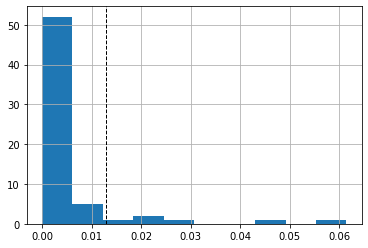

In [111]:
df_111['dev'] = abs(df_111['TARGET']-(df_111['TARGET']+df_111['Experiment']+df_111['Experiment'])/3)/df_111['TARGET']
df_111['dev'].hist()
# Find lower 10% max value
max_10_percent_val = np.sort(df_111['dev'].values)[-int(len(df_111)/10):][0]
plt.axvline(max_10_percent_val, color='k', linestyle='dashed', linewidth=1)

In [112]:
# Printed values to the left of the 
df_111.sort_values(by=['dev'],ascending=False).head(int(len(df_111)/10))

,SMILES,TARGET,Experiment,RON,dev
153,CCCCC=C(C)C,83.6,75.9,79.8,0.0614035
216,CC1CCC(C1)(C)C,81.7,87.7,81.7,0.0489596
104,CCC(=C)C,98.3,102.5,98.3,0.0284842
266,CCC1CCCCCC1,28,29,28,0.0238095
57,CCCC=C,87.9,90.9,87.9,0.0227531
186,CCC1CCCCC1,46.5,45.6,46.5,0.0129032


In [116]:
########################### Decision for molecules to the RIGHT of dashed line ############################

#153 CCCCC=C(C)C     - 79.8 (RON -[3] data source value), since its a mean betwen [1] and [2]
#216 CC1CCC(C1)(C)C	 - 81.7 (RON)
#104 CCC(=C)C        - 98.3 (RON)
#266 CCC1CCCCCC1     - 28   (RON)
#57  CCCC=C          - 87.9 (RON)
#186 CCC1CCCCC1      - 46.5 (RON)

########################### Decision for molecules to the LEFT of dashed line ############################

# all octane numbers from (TARGET)

#### T=1 E=1 R=1

In [ ]:
X_train_validate = df_octane[df_octane['Data Set'].isin(['Training','Validation'])][descriptors].values
Y_train_validate = df_octane[df_octane['Data Set'].isin(['Training','Validation'])]['Exeriment'].values

scaler.fit(X_train_validate)

X_train_validate = scaler.transform(X_train_validate)


X_test = df_octane[df_octane['Data Set'] == 'Test'][descriptors].values

X_test = scaler.transform(X_test)
Y_test = df_octane[df_octane['Data Set'] == 'Test']['Exeriment'].values

In [ ]:
reg = SVR(gamma='auto')


# Build step forward feature selection
sfs1 = sfs(reg,
           k_features=25,
           forward=True,
           floating=False,
           verbose=0,
           scoring='neg_mean_squared_error',
           cv=10)

# Perform SFFS
sfs1 = sfs1.fit(X_train_validate, Y_train_validate)

index = np.array(sfs1.k_feature_idx_)
selected_features = np.take(descriptors,index)


In [ ]:
index = np.array(sfs1.k_feature_idx_)
np.take(np.array(descriptors),index)

In [ ]:
selected_features = np.take(np.array(descriptors),index)

In [ ]:
selected_features

In [ ]:
X_train_validate = df_octane[df_octane['Data Set'].isin(['Training','Validation'])][selected_features].values
X_train_validate = scaler.fit_transform(X_train_validate)

In [ ]:
reg = SVR()

space  = [Real(10**-3, 10**3,"log-uniform", name='C'),
          Real(10**-3, 10**-1,"log-uniform", name='gamma'),
         Real(0.03,0.4,name='epsilon')]

@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X_train_validate, Y_train_validate, cv=10, n_jobs=-1,
                                    scoring="neg_mean_squared_error"))

res_gp = gp_minimize(objective, space, n_calls=50, random_state=0, n_random_starts=5)

In [ ]:
plot_convergence(res_gp)

In [ ]:
reg.C = res_gp.x[0]
reg.gamma = res_gp.x[1]
reg.epsilon = res_gp.x[2]

reg.fit(X_train_validate,Y_train_validate)

In [ ]:
X_train_validate.shape

In [ ]:
print ('RMSE = {}'.format(np.sqrt(mean_squared_error(Y_train_validate, reg.predict(X_train_validate)))))
print ('R2 = {}'.format(r2_score(reg.predict(X_train_validate),Y_train_validate)))
print ('AAE = {}'.format(mean_absolute_error(reg.predict(X_train_validate),Y_train_validate)))


In [ ]:
X_test = df_octane[df_octane['Data Set']== 'Test'][selected_features].values
X_test = scaler.transform(X_test)

In [ ]:
print ('RMSE = {}'.format(np.sqrt(mean_squared_error(Y_test, reg.predict(X_test)))))
print ('R2 = {}'.format(r2_score(reg.predict(X_test),Y_test)))
print ('AAE = {}'.format(mean_absolute_error(reg.predict(X_test),Y_test)))

In [ ]:
plt.scatter(reg.predict(X_test),Y_test)

x = np.linspace(45,120)
y = x

plt.plot(x, y, '-r', label='ideal')
plt.show()

In [ ]:
plt.scatter(reg.predict(X_train_validate),Y_train_validate)

x = np.linspace(0,140)
y = x

plt.plot(x, y, '-r', label='ideal')
plt.show()

In [ ]:
type(calc)

In [ ]:
selected_features

In [ ]:
#calc = Calculator(descriptors, ignore_3D=False)
mols = [Chem.MolFromSmiles(smi) for smi in ['CC1CCC(=O)O1','CNC1=CC=CC=C1']]
df_descriptors = calc.pandas(mols)

In [ ]:
#calc = Calculator(descriptors, ignore_3D=False)
mols = [Chem.MolFromSmiles(smi) for smi in ['CCCC(C)CC','CC(C)(C)C=C']]
df_descriptors = calc.pandas(mols)

In [ ]:
x_test_compound = df_descriptors[selected_features]

In [ ]:
x_test_compound.shape

In [ ]:
x_test_compound = scaler.transform(x_test_compound)

In [ ]:
reg.predict(x_test_compound)